# Image Captioning project
Build our first prototype model for Image captioning using structure combination of CNN and Transformer.

In [1]:
name_1 = 'Qinghuan Liu'
name_2 = 'Jingkai Zhou'
name_3 = 'Chang Li'
naem_4 = 'Yawen Liu'
planning_group = '28'

---
## 0. Import
import possible files here:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


---
## 1. Load dataset
In this part, load and preprocess famous captioning dataset ['Flickr 8k Dataset'](https://www.kaggle.com/datasets/adityajn105/flickr8k). 

---
### 1.1 Load dataset from disk and split into training / validation / test sets
Since the size of our trainning archive is not relatively large, the ratio is chosen according to the technique [Data splitting technique to fit any Machine Learning Model](https://towardsdatascience.com/data-splitting-technique-to-fit-any-machine-learning-model-c0d7f3f1c790)

In [3]:
from pathlib import Path
# Some file system operation are not covered by 'Path' and we use 'shutil' for that
import shutil

# Regular expressions are used to find patterns in strings
import re

# For splitting the data
from sklearn.model_selection import train_test_split





C:\Users\jingkai\.conda\envs\dml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Statistical information on dataset:

In [4]:
# Path to Flickr8K_ photos
path_Flickr_jpg = "G:/GitHub/Deep_Learning_Proj/archive/Images"
# Path to caption file
path_Flickr_text = "G:/GitHub/Deep_Learning_Proj/archive/captions.txt"

image_all = Path.cwd() / "G:/GitHub/Deep_Learning_Proj/archive/Images/"

all_image_filenames = list(image_all.glob("*.jpg"))

print(len(all_image_filenames))
print(all_image_filenames[0])

8091
G:\GitHub\Deep_Learning_Proj\archive\Images\1000268201_693b08cb0e.jpg


split data with predefined ratio

In [6]:
split_ratio_dataset = 0.2

image_train, image_val = \
train_test_split(all_image_filenames,  
              test_size = split_ratio_dataset,
              random_state = 2)

# Following operations create train and val dataset folders located at the same root as this proj.ipynb
subdirectories = {"./image_train": image_train,
                 "./image_val": image_val
                 }

for subdirectory in subdirectories.keys():
    subdirectory = Path(subdirectory)
    subdirectory.mkdir(parents=True, exist_ok=True)
    
    
# Put the training and validation data in the respective folders
def fill_sub_dir(sub_dir, file_subset):
    """This function copies files from the `train_all` to a `<sub_dir>`
    A more efficient solution would be to use "symbolic links" (see https://kb.iu.edu/d/abbe)
    but for simplicity hard copies is used instead.
    """
    for file in file_subset:
        file_path = Path.cwd() / sub_dir / file.name
        shutil.copyfile(file, file_path)
        
for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)


In [7]:
print(len(image_train))
print(len(image_val))

6472
1619


Point to training and validation path.

In [8]:
train_path = "./image_train/"
val_path = "./image_val/"
cap_train_path = "./cap_train.txt"
cap_val_path = "./cap_val.txt"

## 1.2 Import image classes
Here, as what we did before in HA1, new useful classes are created in another file 'data_loader.py'

In [9]:
#imports 
import os
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image

class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
        
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        
        #staring index 4
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
    
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset
    
    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset 
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)  
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader

In [13]:
#for image plot
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
#imports 

#reading the training text data 
import pandas as pd
caption_file = './cap_train.txt'
df = pd.read_csv(caption_file)
print("There are {} train captions".format(len(df)))
df.head(7)


import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

#custom imports 
# from data_loader import FlickrDataset,get_data_loader


#setting the constants
BATCH_SIZE = 128
NUM_WORKER = 0

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = './image_train/',
    caption_file = './cap_train.txt',
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)


There are 32360 train captions


## 2 Build learning model
In this part, learning model should be built for. And test it.

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim



class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
        
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 2.1 Setting hyperparams for training


Epoch: 1 loss: 4.67263


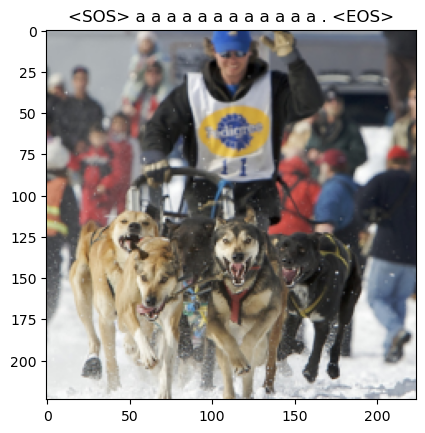

Epoch: 1 loss: 4.22044


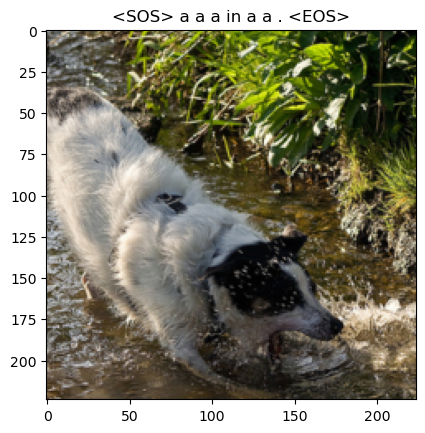

Epoch: 2 loss: 3.90091


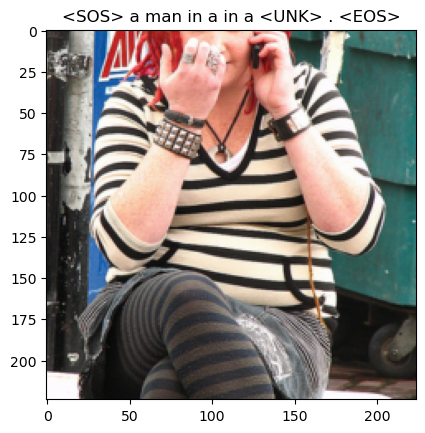

Epoch: 2 loss: 3.77145


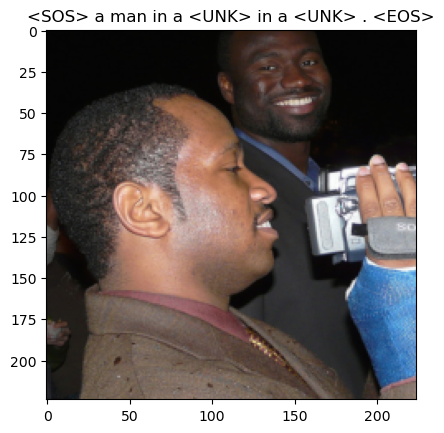

Epoch: 3 loss: 3.58932


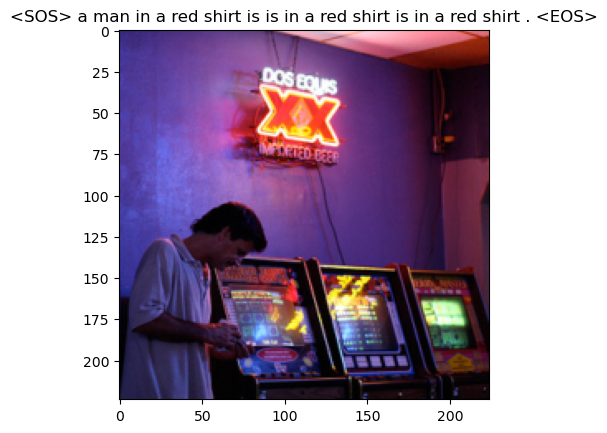

Epoch: 3 loss: 3.52792


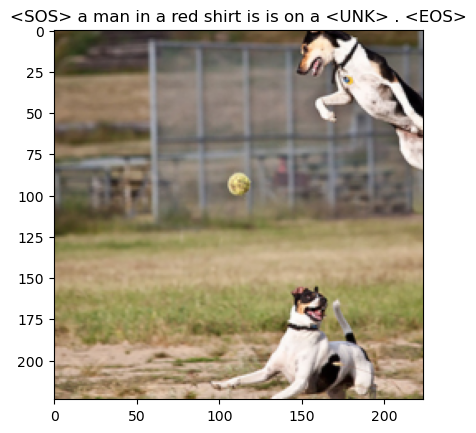

Epoch: 4 loss: 3.49124


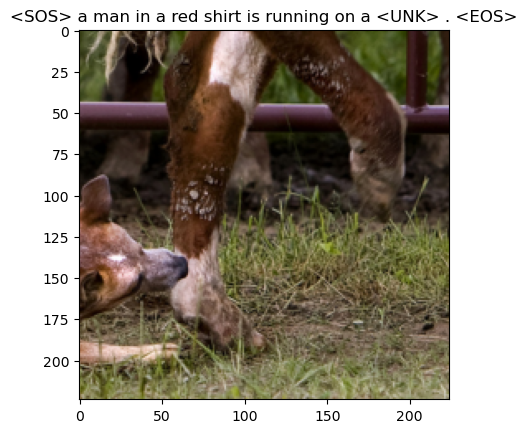

Epoch: 4 loss: 3.34136


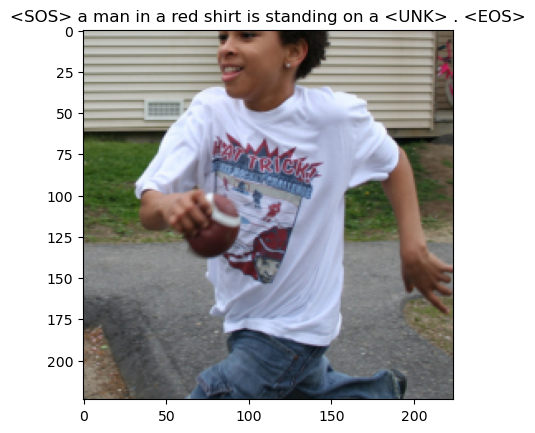

Epoch: 5 loss: 3.22948


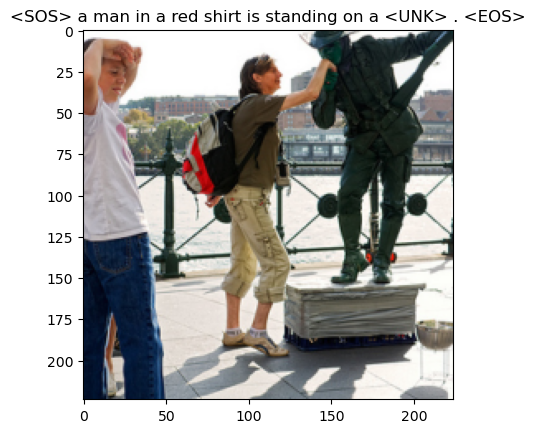

Epoch: 5 loss: 3.16879


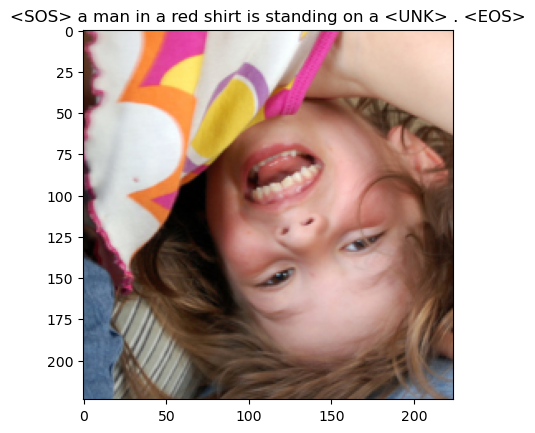

Epoch: 6 loss: 3.10456


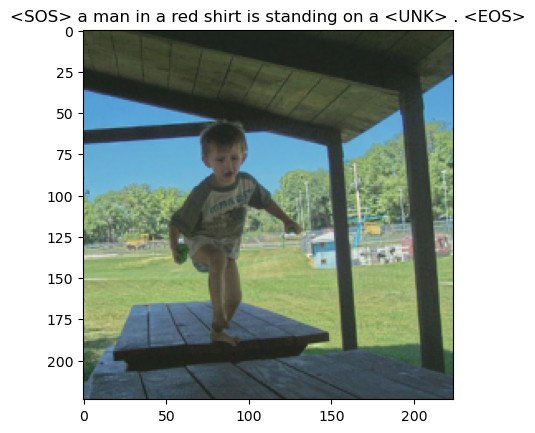

Epoch: 6 loss: 3.04655


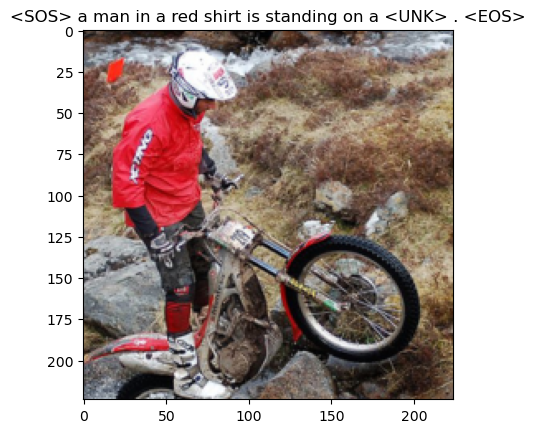

Epoch: 7 loss: 3.00728


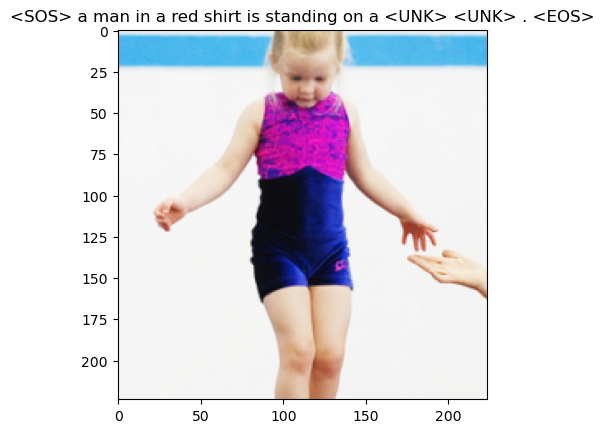

Epoch: 7 loss: 2.91118


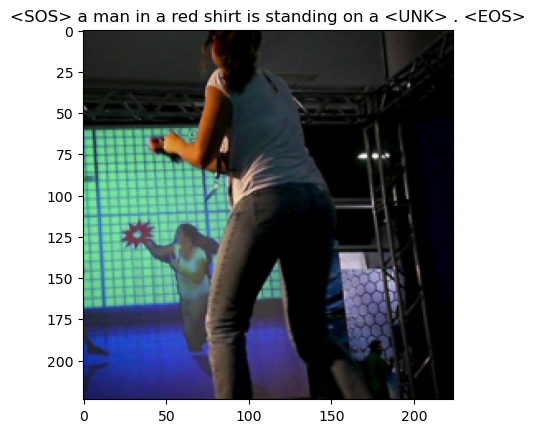

Epoch: 8 loss: 2.94388


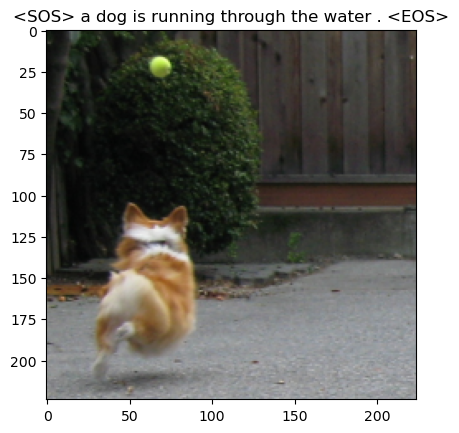

Epoch: 8 loss: 2.86463


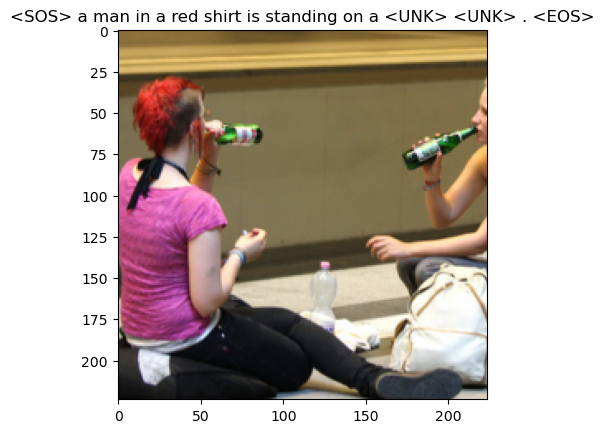

Epoch: 9 loss: 2.71809


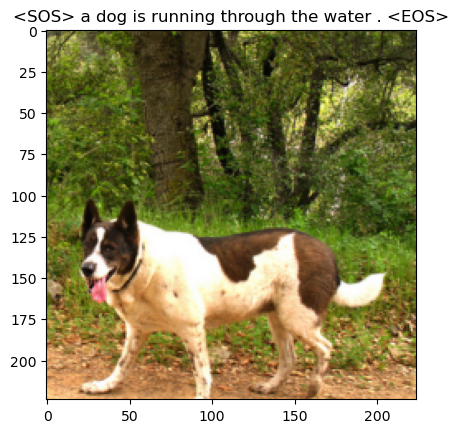

Epoch: 9 loss: 2.79809


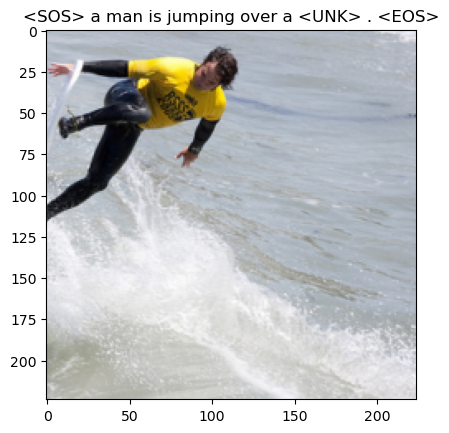

Epoch: 10 loss: 2.73029


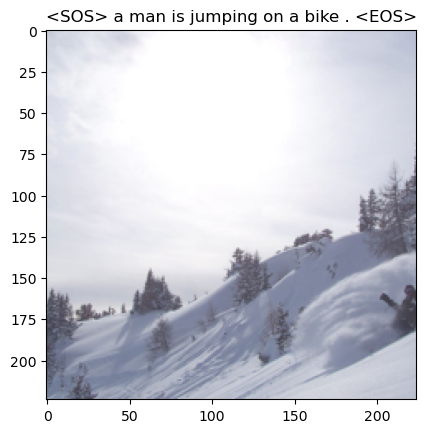

Epoch: 10 loss: 2.67212


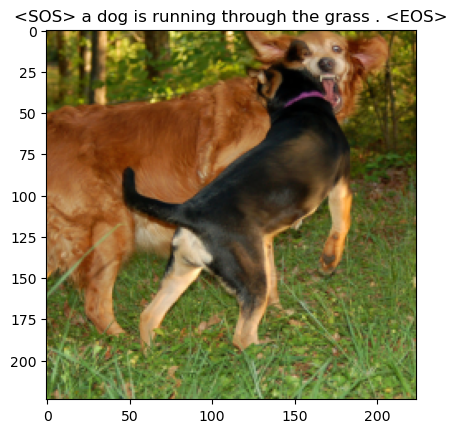

Epoch: 11 loss: 2.67408


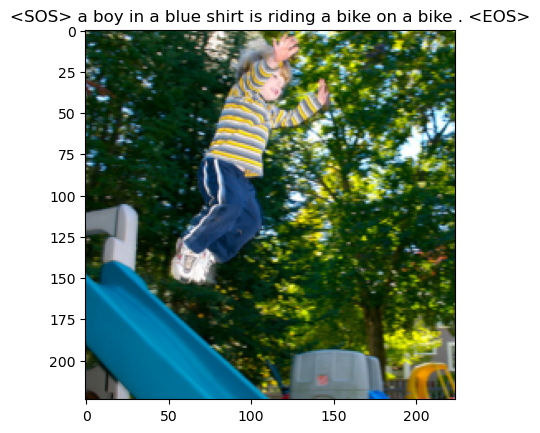

Epoch: 11 loss: 2.63541


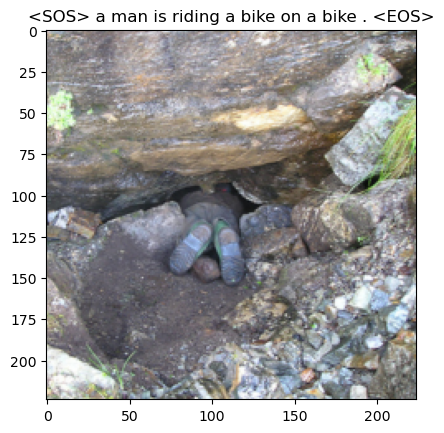

Epoch: 12 loss: 2.66778


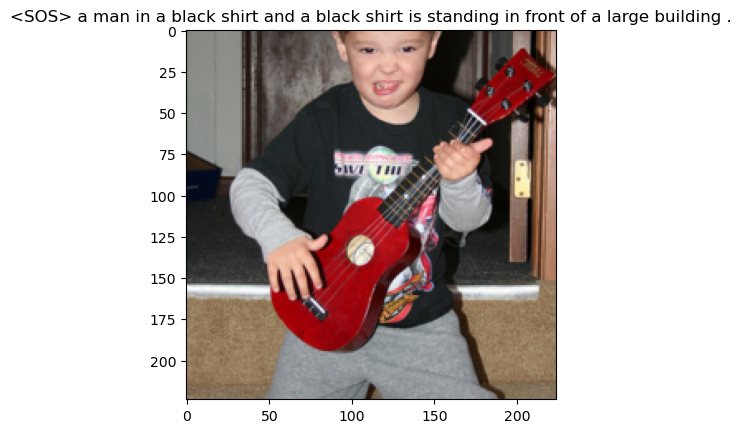

Epoch: 12 loss: 2.60865


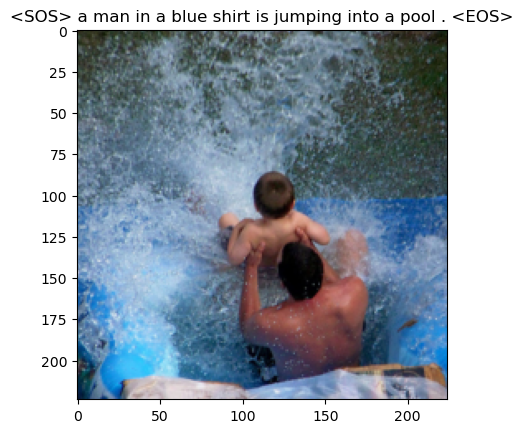

Epoch: 13 loss: 2.64334


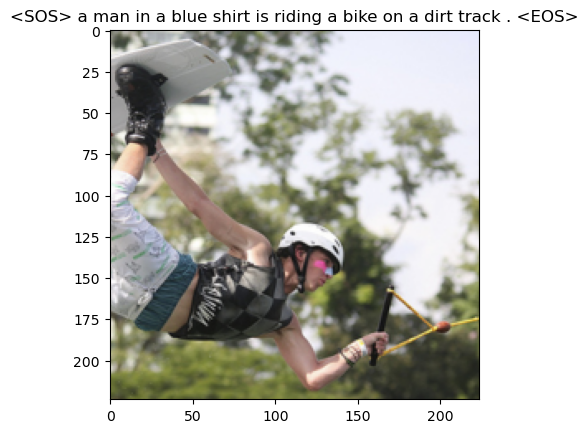

Epoch: 13 loss: 2.51734


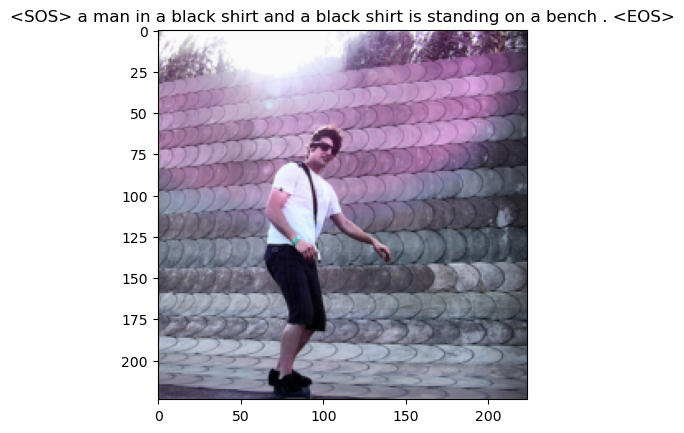

Epoch: 14 loss: 2.45246


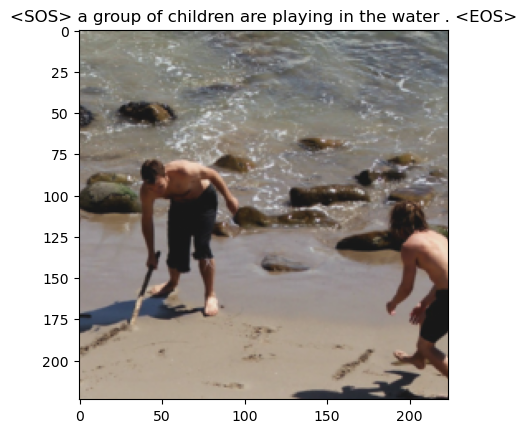

Epoch: 14 loss: 2.56378


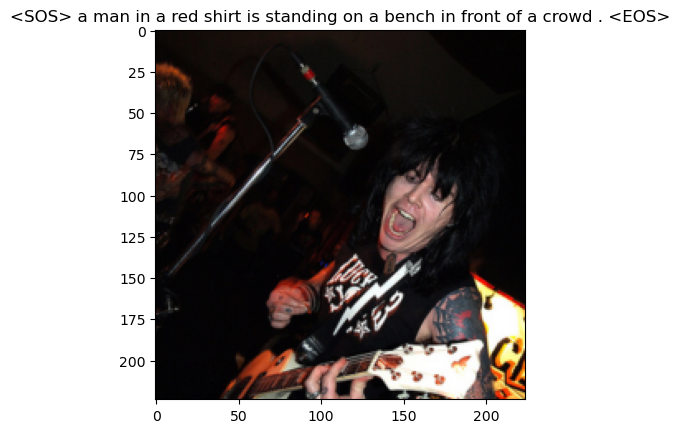

Epoch: 15 loss: 2.59639


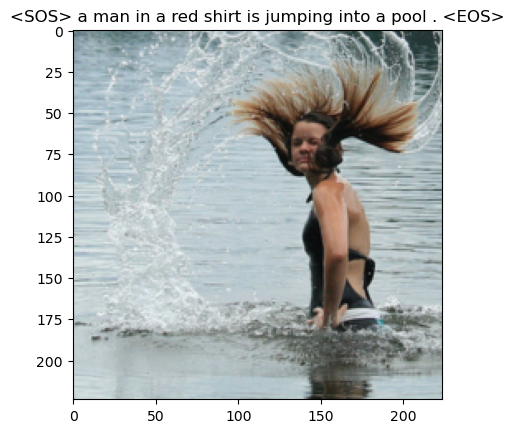

In [ ]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



num_epochs = 20
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()